## Import Packages

In [9]:
# !pip install pybaseball
# !pip install pandas
# !pip install scikit-learn
# !pip install seaborn
# !pip install imblearn
# !pip install ipykernel

%pip install pybaseball
%pip install pandas
%pip install scikit-learn
%pip install seaborn
%pip install imblearn
%pip install ipykernel

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [10]:
from pybaseball import statcast, cache
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.kernel_approximation import RBFSampler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, make_scorer, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score
from matplotlib import pyplot as plt, cm
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import time
import joblib
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import json

SKENES_ID = 694973
pitch_types_key = pd.read_csv('./data/pitch_types.csv', header=None).loc[0,:]

## Load and Clean Data

In [11]:
data = pd.read_csv('./data/clean_data.csv')

pitcher = data['pitcher']
X = data.drop(['player_name', 'pitch_type', 'pitcher'], axis=1)
y = np.asarray(data['pitch_type'])

print(pd.Series(y).groupby(y).count())

# Scale data before applying PCA
scaling=StandardScaler()

# Use fit and transform method
scaling.fit(X)
scaled_X = pd.DataFrame(scaling.transform(X), columns=X.columns)

FS    10092
SI    54536
dtype: int64


## Multicollinearity

In [12]:
np.random.seed(42)
sample = np.random.randint(scaled_X.shape[0], size=(100))

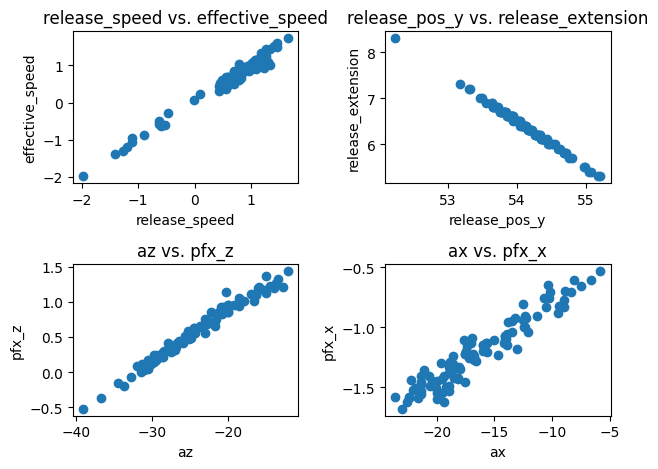

In [13]:
fig, ax = plt.subplots(2, 2)
scatter = ax[0][0].scatter(X.loc[sample, 'release_speed'], X.loc[sample, 'effective_speed'])
ax[0][0].set_xlabel('release_speed')
ax[0][0].set_ylabel('effective_speed')
ax[0][0].set_title('release_speed vs. effective_speed')

scatter = ax[0][1].scatter(X.loc[sample, 'release_pos_y'], X.loc[sample, 'release_extension'])
ax[0][1].set_xlabel('release_pos_y')
ax[0][1].set_ylabel('release_extension')
ax[0][1].set_title('release_pos_y vs. release_extension')

scatter = ax[1][0].scatter(X.loc[sample, 'az'], X.loc[sample, 'pfx_z'])
ax[1][0].set_xlabel('az')
ax[1][0].set_ylabel('pfx_z')
ax[1][0].set_title('az vs. pfx_z')

scatter = ax[1][1].scatter(X.loc[sample, 'ax'], X.loc[sample, 'pfx_x'])
ax[1][1].set_xlabel('ax')
ax[1][1].set_ylabel('pfx_x')
ax[1][1].set_title('ax vs. pfx_x')
fig.tight_layout()
plt.show()

In [14]:
# sns.pairplot(X.drop(['release_speed', 'release_pos_y', 'pfx_x', 'pfx_z', 'p_throws_r'], axis=1).iloc[sample,:])
# plt.show()

## PCA

[np.float64(0.29019588086551884), np.float64(0.4489287724517624), np.float64(0.5825386260883683), np.float64(0.70411493061622), np.float64(0.781786893957301), np.float64(0.8482672851982062), np.float64(0.895408527290484), np.float64(0.9331423852200806), np.float64(0.9553607070727641), np.float64(0.976737761515297)]


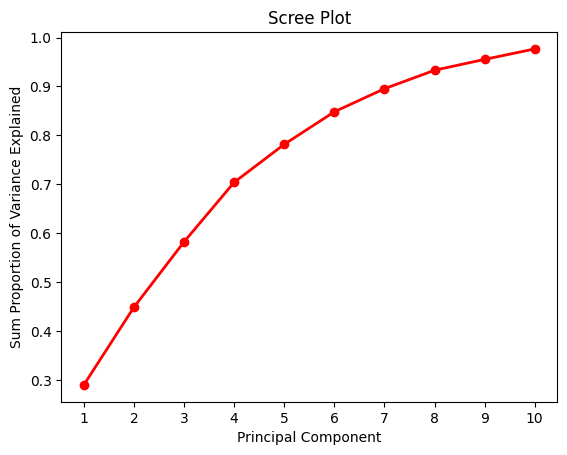

([<matplotlib.lines.Line2D object at 0x000001CD5D240080>, <matplotlib.lines.Line2D object at 0x000001CD5D24EE40>], ['$\\mathdefault{0}$', '$\\mathdefault{1}$'])


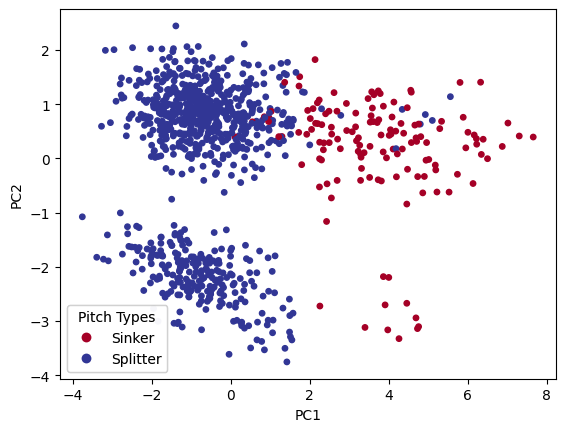

In [15]:
X = scaled_X.drop(['release_speed', 'release_pos_y', 'pfx_x', 'pfx_z'], axis=1)

pca = PCA(n_components=10, random_state=42)
pca.fit(X)

print([pca.explained_variance_ratio_[:i+1].sum() for i in range(len(pca.explained_variance_ratio_))])
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, [pca.explained_variance_ratio_[:i+1].sum() for i in range(len(pca.explained_variance_ratio_))], 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.xticks(range(1,11))
plt.ylabel('Sum Proportion of Variance Explained')
plt.show()

X_pca = pca.transform(X)

sample = np.random.randint(X_pca.shape[0], size=(1000))

sample_X_pca, sample_y = X_pca[sample,:], y[sample]
fig, ax = plt.subplots()
scatter = ax.scatter(X_pca[sample, 0], X_pca[sample, 1], c=y[sample]=='SI', cmap='RdYlBu', label=y[sample], s=15)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
print(scatter.legend_elements())
legend1 = ax.legend(scatter.legend_elements()[0], ['Sinker' if x=='SI' else 'Splitter' for x in pitch_types_key], loc='lower left', title='Pitch Types')
ax.add_artist(legend1)
plt.show()

In [16]:
pca = PCA(n_components=8, random_state=42)
pca.fit(X, y)
X_pca_all = pca.transform(X)

loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8'], index=X.columns)
print(loadings)

                        PC1       PC2       PC3       PC4       PC5       PC6  \
effective_speed   -0.421982 -0.004553  0.118120  0.023356 -0.000230  0.173304   
release_spin_rate -0.429579  0.020819  0.123677  0.057120 -0.060620  0.147163   
release_pos_x     -0.058386 -0.645929  0.065464 -0.174359  0.011100 -0.199919   
release_extension  0.016868  0.061927 -0.181616  0.083923  0.897396 -0.311674   
plate_x           -0.032109 -0.322105 -0.171339  0.329062  0.190387  0.642634   
plate_z           -0.109804  0.032468  0.596485 -0.257998  0.274337  0.244121   
vx0               -0.140586 -0.132504 -0.055049  0.645610  0.054674  0.046923   
vy0                0.459256 -0.140681  0.020055  0.061409 -0.015035  0.013702   
vz0                0.145847  0.025412  0.675629  0.197020  0.151308 -0.000092   
ax                 0.365941 -0.014607 -0.042069 -0.332006  0.129499  0.365831   
ay                -0.389236  0.128354  0.004986 -0.073216  0.020946 -0.269881   
az                -0.278263 

## Separate Skenes Test Data

In [17]:
X_skenes, y_skenes = X_pca_all[pitcher==SKENES_ID, :], y[pitcher==SKENES_ID]
X_pca, y = X_pca_all[pitcher!=SKENES_ID, :], y[pitcher!=SKENES_ID]

print(f'Skenes data has {X_skenes.shape[0]} rows.')
print(f'Other data has {X_pca.shape[0]} rows.')

Skenes data has 335 rows.
Other data has 64293 rows.


## CV for Classifiers

In [18]:
def optimize(clf, X, y, param):
    score={'RECALL':'recall_micro',
           'PRECISION':'precision_micro',
           'F1':'f1_micro'}


    gcv = GridSearchCV(estimator=clf, param_grid=param, cv=5, scoring=score, n_jobs=-1, refit='F1',
                       return_train_score=True, verbose=4)
    tic = time.perf_counter()
    gcv.fit(X, y)
    toc = time.perf_counter()

    runtime = toc - tic

    return gcv, runtime

In [19]:
params =        [
                    {'n_neighbors': (5, 10, 15, 20, 25, 30, 35)}, #15 min
                    {'l1_ratio': (0, 0.25, 0.5, 0.75, 1), 'C': (0.01, 0.1, 1.0, 10, 100)}, #30 min
                    {'penalty': ('l1', 'l2'), 'C': (0.01, 0.1, 1, 10, 100)}, #15 min
                    {'n_estimators': (16, 32, 64, 128), 'max_depth': tuple(range(1, 32, 5))} #1 hr
                ]
classifiers =   [
                    ('K Nearest Neighbors', KNeighborsClassifier()),
                    ('Logistic Regression', LogisticRegression(max_iter=100, solver='saga', penalty='elasticnet')),
                    ('Linear SVM', LinearSVC()),
                    ('Random Forest', RandomForestClassifier())
                ]

optimized_classifiers = {}
for param, (name, clf) in zip(params, classifiers):
    print(f'Working on {name}...')
    gcv, runtime = optimize(clf, X_pca, y, param)
    print(f'{name} finished in {int(runtime)//60} minutes and {int(runtime)%60} seconds')
    print(f'Best parameter for {name} is {gcv.best_params_}')
    print(f'Best `F1` for {name} is {gcv.best_score_}')
    optimized_classifiers[name] = gcv
    print('-'*50)
    print('\n')



Working on K Nearest Neighbors...
Fitting 5 folds for each of 7 candidates, totalling 35 fits


c:\Users\student\Documents\School\Sum2024\ISYE6740\Final Project\.venv\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


K Nearest Neighbors finished in 4 minutes and 23 seconds
Best parameter for K Nearest Neighbors is {'n_neighbors': 5}
Best `F1` for K Nearest Neighbors is 0.9933741040986186
--------------------------------------------------


Working on Logistic Regression...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Logistic Regression finished in 1 minutes and 50 seconds
Best parameter for Logistic Regression is {'C': 1.0, 'l1_ratio': 0}
Best `F1` for Logistic Regression is 0.9888168648189438
--------------------------------------------------


Working on Linear SVM...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Linear SVM finished in 0 minutes and 37 seconds
Best parameter for Linear SVM is {'C': 1, 'penalty': 'l2'}
Best `F1` for Linear SVM is 0.9887546540023202
--------------------------------------------------


Working on Random Forest...
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Random Forest finished in 8 minutes and 31 seconds
Best para

In [20]:
param = {'C': (0.1, 1, 10, 100, 1000)} #1 hr
name, clf = ('Kernel SVM', LinearSVC())
print(f'Working on {name}...')

score={'RECALL':'recall_micro',
        'PRECISION':'precision_micro',
        'F1':'f1_micro'}

tic = time.perf_counter()
kernel_svm_best_params = None
kernel_svm_best_score = 0
kernel_svm_cv_results = {}
print('Fitting 5 folds for each of 20 candidates, totalling 100 fits')
for i, gamma in enumerate((0.001, 0.01, 0.1, 1, 10)):
    gcv = GridSearchCV(estimator=clf, param_grid=param, cv=5, scoring=score, n_jobs=-1, refit='F1',
                    return_train_score=True, verbose=4)
    kernel = RBFSampler(gamma=gamma)
    tic1 = time.perf_counter()
    gcv.fit(kernel.fit_transform(X_pca), y)
    toc1 = time.perf_counter()
    print(f'Iteration {i+1} finished in {int(toc1-tic1)//60} minutes and {int(toc1-tic1)%60} seconds')
    if gcv.best_score_ > kernel_svm_best_score:
        kernel_svm_best_score = gcv.best_score_
        kernel_svm_best_params = {'gamma': gamma, **gcv.best_params_}
    if kernel_svm_cv_results == {}:
        kernel_svm_cv_results = gcv.cv_results_
        kernel_svm_cv_results['param_gamma'] = [gamma]*5
    else:
        for key in kernel_svm_cv_results.keys():
            if key == 'param_gamma':
                kernel_svm_cv_results[key] = [*kernel_svm_cv_results[key], *([gamma]*5)]
            else:
                kernel_svm_cv_results[key] = [*kernel_svm_cv_results[key], *gcv.cv_results_[key]]
toc = time.perf_counter()

runtime = toc - tic

print(f'{name} finished in {int(runtime)//60} minutes and {int(runtime)%60} seconds')
print(f'Best parameter for {name} is {kernel_svm_best_params}')
print(f'Best `F1` for {name} is {kernel_svm_best_score}')
print('-'*50)
print('\n')

Working on Kernel SVM...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Iteration 1 finished in 0 minutes and 30 seconds
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Iteration 2 finished in 0 minutes and 32 seconds
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Iteration 3 finished in 0 minutes and 31 seconds
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Iteration 4 finished in 0 minutes and 33 seconds
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Iteration 5 finished in 0 minutes and 24 seconds
Kernel SVM finished in 2 minutes and 32 seconds
Best parameter for Kernel SVM is {'gamma': 0.01, 'C': 1000}
Best `F1` for Kernel SVM is 0.9925964313925675
--------------------------------------------------




In [21]:
for name, gcv in optimized_classifiers.items():
    filename = name.lower().replace(' ', '_')
    joblib.dump(gcv, f'./output/gcv_outputs/{filename}.pkl')

# with open('kernel_svm.json', 'w') as f:
#     print(kernel_svm_cv_results)
#     kernel_svm_dict = {
#         'best_params_': kernel_svm_best_params,
#         'best_score_': kernel_svm_best_score,
#         'cv_results_': kernel_svm_cv_results
#     }
#     json.dump(kernel_svm_dict, f, indent=4)

## Evaluating CV

In [22]:
knn_gcv, log_reg_gcv, linear_svm_gcv, random_forest_gcv = \
    [joblib.load(f'./output/gcv_outputs/{name.lower().replace(' ', '_')}.pkl') for name in ['K Nearest Neighbors', 'Logistic Regression', 'Linear SVM', 'Random Forest']]

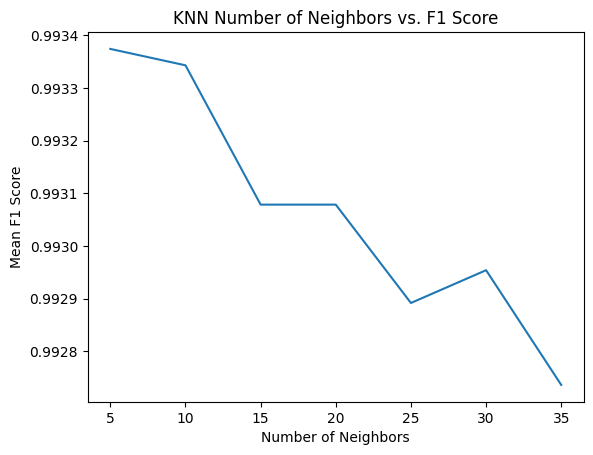

In [23]:
knn_cv_results = pd.DataFrame(knn_gcv.cv_results_)

plt.plot(knn_cv_results.param_n_neighbors, knn_cv_results.mean_test_F1)
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean F1 Score')
plt.title('KNN Number of Neighbors vs. F1 Score')
plt.savefig('./output/knn_cv_results.png')
plt.show()

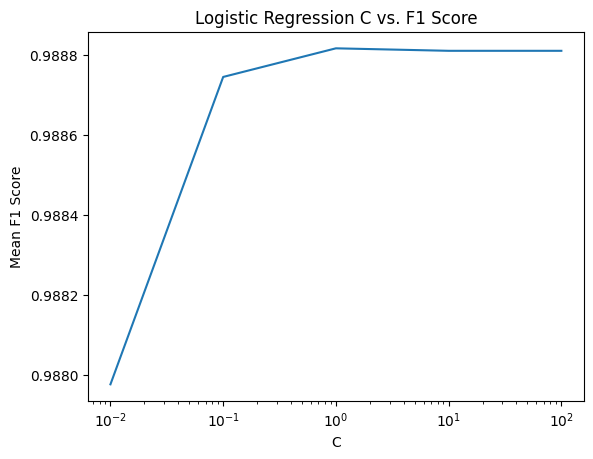

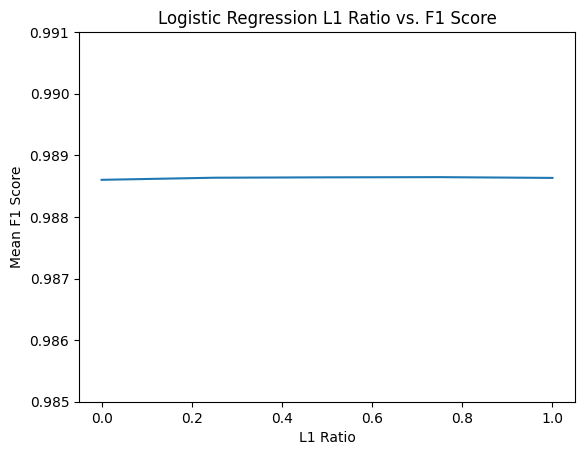

In [35]:
log_reg_cv_results = pd.DataFrame(log_reg_gcv.cv_results_)

log_reg_cv_results.groupby('param_C')['mean_test_F1'].mean().plot(xlabel='C', ylabel='Mean F1 Score', title='Logistic Regression C vs. F1 Score', logx=True)
plt.savefig('./output/log_reg_cv_results(a).png')
plt.show()
log_reg_cv_results.groupby('param_l1_ratio')['mean_test_F1'].mean().plot(xlabel='L1 Ratio', ylabel='Mean F1 Score', title='Logistic Regression L1 Ratio vs. F1 Score', ylim=(0.985,0.991))
plt.savefig('./output/log_reg_cv_results(b).png')
plt.show()

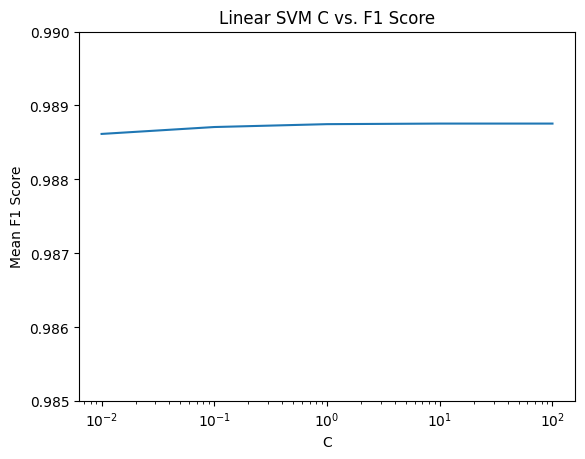

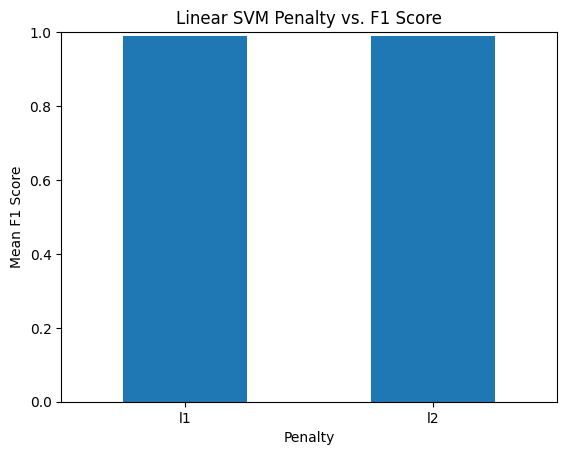

In [37]:
linear_svm_cv_results = pd.DataFrame(linear_svm_gcv.cv_results_)
linear_svm_cv_results

linear_svm_cv_results.groupby('param_C')['mean_test_F1'].mean().plot(xlabel='C', ylabel='Mean F1 Score', title='Linear SVM C vs. F1 Score', logx=True, ylim=(0.985, 0.99))
plt.savefig('./output/linear_svm_cv_results(a).png')
plt.show()
linear_svm_cv_results.groupby('param_penalty')['mean_test_F1'].mean().plot(xlabel='Penalty', ylabel='Mean F1 Score', title='Linear SVM Penalty vs. F1 Score', kind='bar', rot=0, ylim=(0, 1))
plt.savefig('./output/linear_svm_cv_results(b).png')
plt.show()

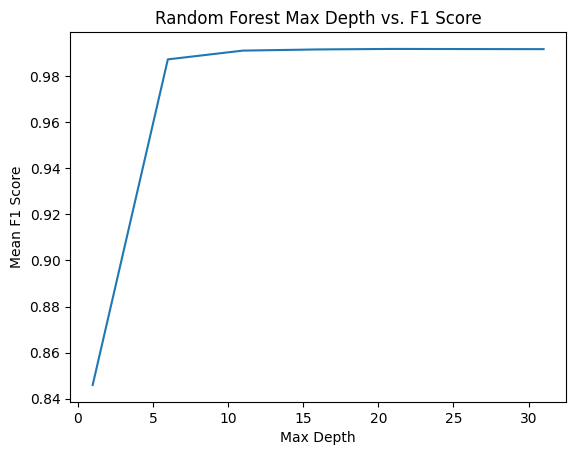

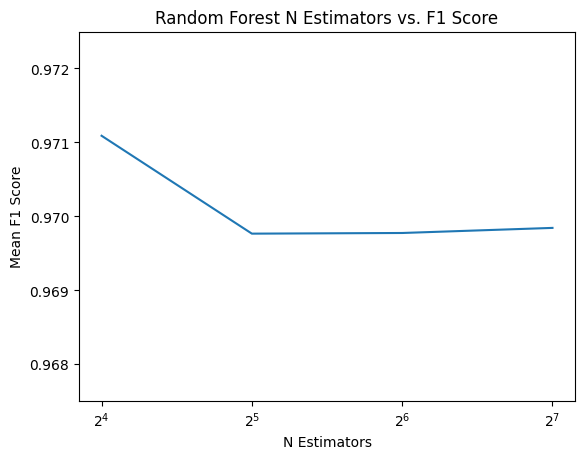

In [39]:
random_forest_cv_results = pd.DataFrame(random_forest_gcv.cv_results_)

random_forest_cv_results.groupby('param_max_depth')['mean_test_F1'].mean().plot(xlabel='Max Depth', ylabel='Mean F1 Score', title='Random Forest Max Depth vs. F1 Score')
plt.savefig('./output/random_forest_cv_results(a).png')
plt.show()
random_forest_cv_results.groupby('param_n_estimators')['mean_test_F1'].mean().plot(xlabel='N Estimators', ylabel='Mean F1 Score', title='Random Forest N Estimators vs. F1 Score', ylim=(0.9675, 0.9725))
plt.xscale('log', base=2)
plt.savefig('./output/random_forest_cv_results(b).png')
plt.show()

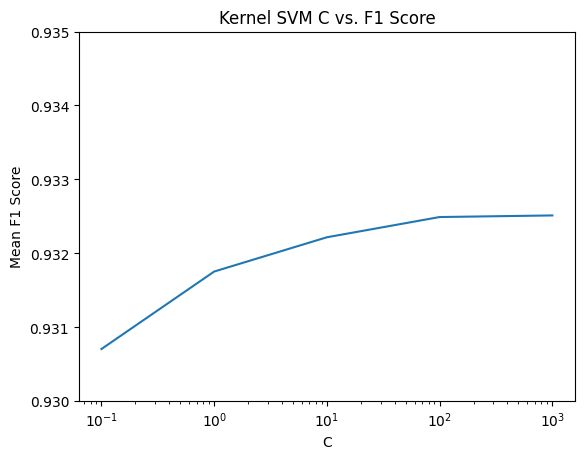

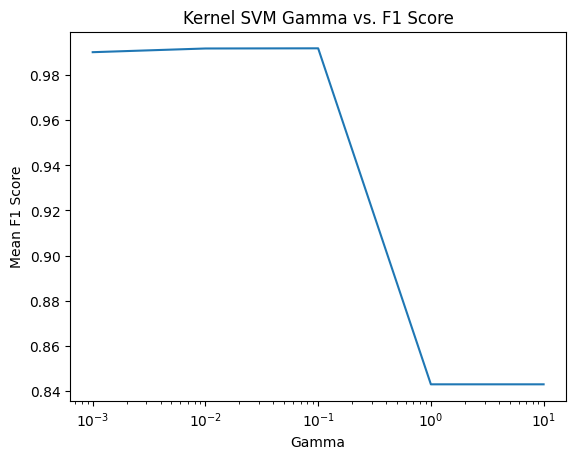

In [40]:
kernel_svm_cv_results_df = pd.DataFrame(kernel_svm_cv_results)

kernel_svm_cv_results_df.groupby('param_C')['mean_test_F1'].mean().plot(xlabel='C', ylabel='Mean F1 Score', title='Kernel SVM C vs. F1 Score', logx=True, ylim=(0.93, 0.935))
plt.savefig('./output/kernel_svm_cv_results(a).png')
plt.show()
kernel_svm_cv_results_df.groupby('param_gamma')['mean_test_F1'].mean().plot(xlabel='Gamma', ylabel='Mean F1 Score', title='Kernel SVM Gamma vs. F1 Score', logx = True)
plt.savefig('./output/kernel_svm_cv_results(b).png')
plt.show()

## Fit Best Models

Split into train and test data

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.1)

Fit models with optimal parameters

In [42]:
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
log_reg = LogisticRegression(C=1, l1_ratio=1, max_iter=100, solver='saga', penalty='elasticnet', n_jobs=-1)
linear_svm = LinearSVC(C=1, penalty='l2')
random_forest = RandomForestClassifier(max_depth=5, n_estimators=16, n_jobs=-1)

for name, model in zip(['KNN', 'Logistic Regression', 'Linear SVM', 'Random Forest'], [knn, log_reg, linear_svm, random_forest]):
    print(f'Fitting {name}...')
    model.fit(X_train, y_train)
    print(f'{name} finished!')


print(f'Fitting Kernel SVM...')
kernel = RBFSampler(gamma=0.1)
kernel_svm = LinearSVC(C=1)
kernel_svm.fit(kernel.fit_transform(X_train), y_train)
print(f'Kernel SVM finished!')

Fitting KNN...
KNN finished!
Fitting Logistic Regression...
Logistic Regression finished!
Fitting Linear SVM...
Linear SVM finished!
Fitting Random Forest...
Random Forest finished!
Fitting Kernel SVM...
Kernel SVM finished!


## Evaluate Models on Test Data

In [43]:
print(pitch_types_key)

for name, model in zip(['KNN', 'Logistic Regression', 'Linear SVM', 'Random Forest'], [knn, log_reg, linear_svm, random_forest]):
    y_pred = model.predict(X_test)
    misclass_rate = 1-accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average=None)
    precision = precision_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average=None)

    print(f'{name}:\nMisclassification Rate: {misclass_rate}\nRecall: {recall}\nPrecision: {precision}\nF1 Score: {f1}\n')


y_pred = kernel_svm.predict(kernel.transform(X_test))
misclass_rate = 1-accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average=None)
precision = precision_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

print(f'Kernel SVM:\nMisclassification Rate: {misclass_rate}\nRecall: {recall}\nPrecision: {precision}\nF1 Score: {f1}\n')

0    SI
1    FS
Name: 0, dtype: object
KNN:
Misclassification Rate: 0.0062208398133748455
Recall: [0.97497497 0.99723808]
Precision: [0.98483316 0.99540526]
F1 Score: [0.97987928 0.99632082]

Logistic Regression:
Misclassification Rate: 0.010730948678071561
Recall: [0.95295295 0.99594918]
Precision: [0.97741273 0.99138563]
F1 Score: [0.96502788 0.99366217]

Linear SVM:
Misclassification Rate: 0.010730948678071561
Recall: [0.95095095 0.99631744]
Precision: [0.97938144 0.99102564]
F1 Score: [0.96495683 0.99366449]

Random Forest:
Misclassification Rate: 0.013530326594090147
Recall: [0.93293293 0.99631744]
Precision: [0.9789916  0.98776926]
F1 Score: [0.95540748 0.99202493]

Kernel SVM:
Misclassification Rate: 0.009642301710730994
Recall: [0.95295295 0.99723808]
Precision: [0.98448811 0.99139667]
F1 Score: [0.96846389 0.99430879]



## See how models classify Skenes' splinker

In [44]:
np.random.seed(42)

for name, model in zip(['KNN', 'Logistic Regression', 'Linear SVM', 'Random Forest'], [knn, log_reg, linear_svm, random_forest]):
    print(f'Fitting {name}...')
    model.fit(X_pca, y)
    print(f'{name} finished!')


print(f'Fitting Kernel SVM...')
kernel = RBFSampler(gamma=0.1)
kernel_svm = LinearSVC(C=100)
kernel_svm.fit(kernel.fit_transform(X_pca), y)
print(f'Kernel SVM finished!')

Fitting KNN...
KNN finished!
Fitting Logistic Regression...
Logistic Regression finished!
Fitting Linear SVM...
Linear SVM finished!
Fitting Random Forest...
Random Forest finished!
Fitting Kernel SVM...
Kernel SVM finished!


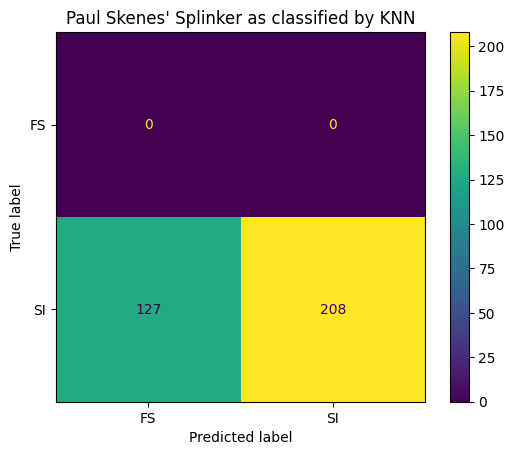

([<matplotlib.lines.Line2D object at 0x000001CD5DB45340>, <matplotlib.lines.Line2D object at 0x000001CD5DB84E90>], ['$\\mathdefault{0}$', '$\\mathdefault{1}$'])


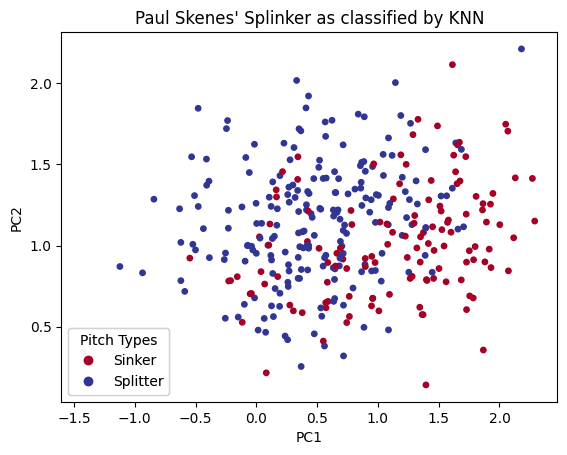

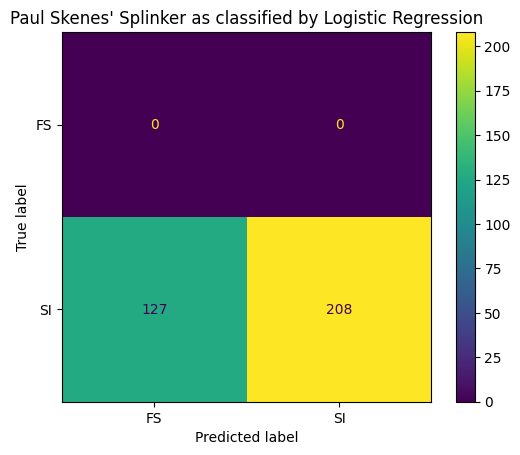

([<matplotlib.lines.Line2D object at 0x000001CD5C952510>, <matplotlib.lines.Line2D object at 0x000001CD5B37F320>], ['$\\mathdefault{0}$', '$\\mathdefault{1}$'])


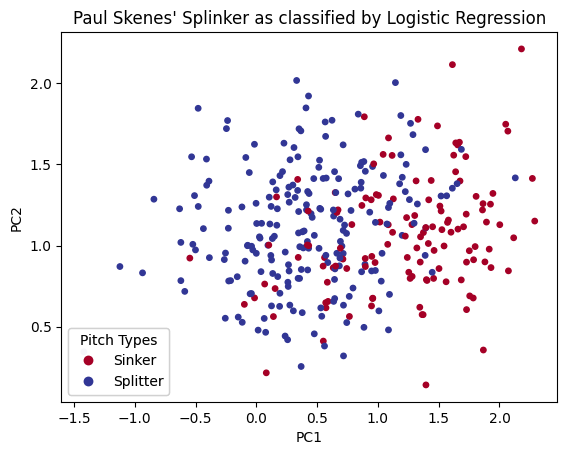

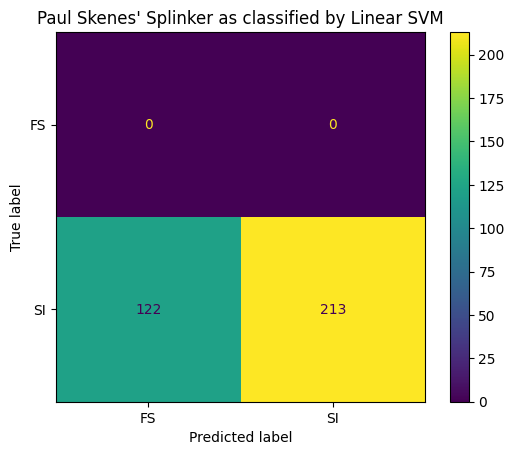

([<matplotlib.lines.Line2D object at 0x000001CD4563D070>, <matplotlib.lines.Line2D object at 0x000001CD59835370>], ['$\\mathdefault{0}$', '$\\mathdefault{1}$'])


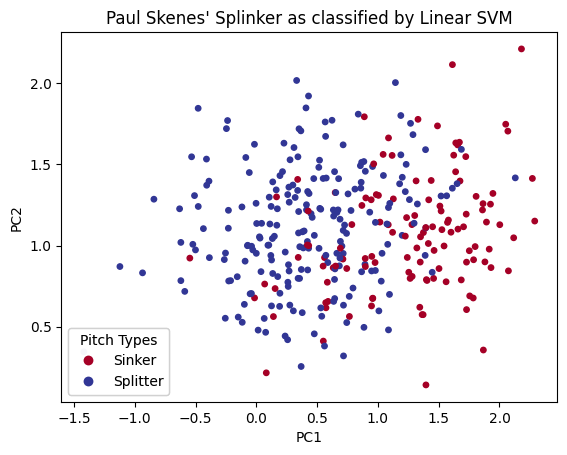

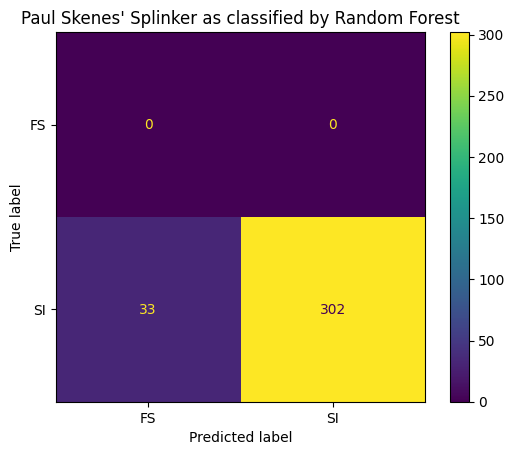

([<matplotlib.lines.Line2D object at 0x000001CD5DA35430>, <matplotlib.lines.Line2D object at 0x000001CD5D242DE0>], ['$\\mathdefault{0}$', '$\\mathdefault{1}$'])


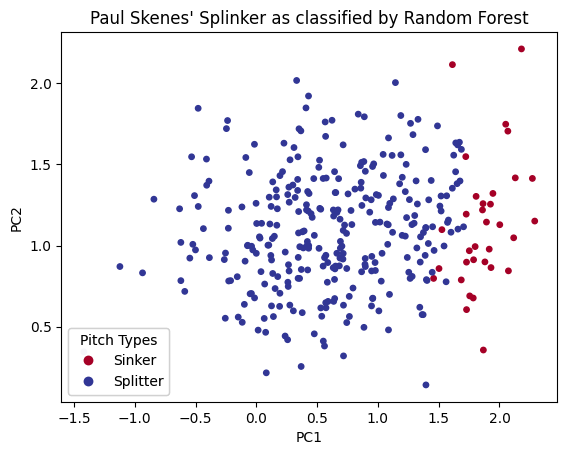

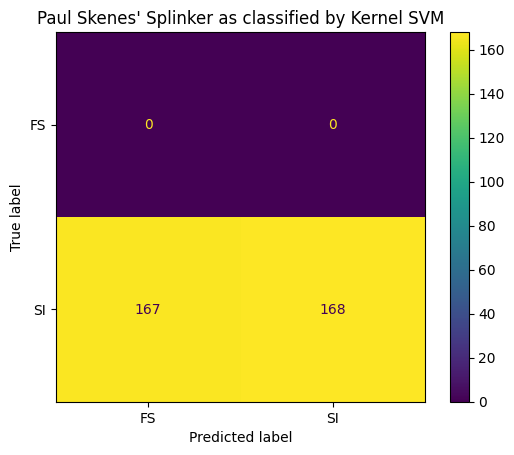

([<matplotlib.lines.Line2D object at 0x000001CD5F398DD0>, <matplotlib.lines.Line2D object at 0x000001CD5C9DEC00>], ['$\\mathdefault{0}$', '$\\mathdefault{1}$'])


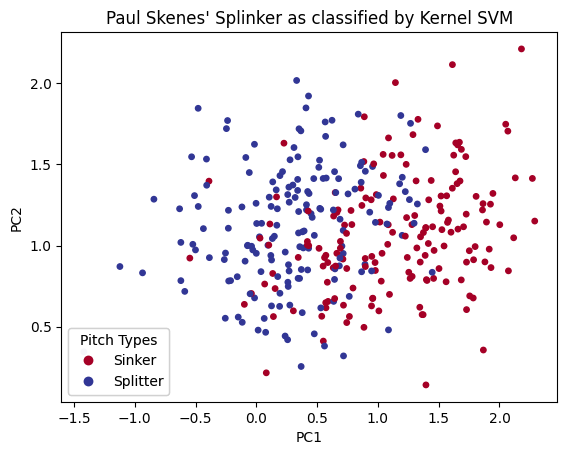

In [47]:
for name, model in zip(['KNN', 'Logistic Regression', 'Linear SVM', 'Random Forest'], [knn, log_reg, linear_svm, random_forest]):
    y_pred = model.predict(X_skenes)

    ConfusionMatrixDisplay.from_predictions(y_skenes, y_pred)
    plt.title(f'Paul Skenes\' Splinker as classified by {name}')
    plt.savefig(f'./output/{name.lower().replace(' ', '_')}_skenes_conf_mat.png')
    plt.show()
    fig, ax = plt.subplots()
    scatter = ax.scatter(X_skenes[:,0], X_skenes[:,1], c=(y_pred=='SI'), cmap='RdYlBu', label=y_pred, s=15)
    ax.set_title(f'Paul Skenes\' Splinker as classified by {name}')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    print(scatter.legend_elements())
    legend1 = ax.legend(scatter.legend_elements()[0], ['Sinker' if x=='SI' else 'Splitter' for x in pitch_types_key], loc='lower left', title='Pitch Types')
    ax.add_artist(legend1)
    plt.savefig(f'./output/{name.lower().replace(' ', '_')}_skenes_scatter.png')
    plt.show()


y_pred = kernel_svm.predict(kernel.transform(X_skenes))

ConfusionMatrixDisplay.from_predictions(y_skenes, y_pred)
plt.title(f'Paul Skenes\' Splinker as classified by Kernel SVM')
plt.savefig(f'./output/{'Kernel SVM'.lower().replace(' ', '_')}_skenes_conf_mat.png')
plt.show()

fig, ax = plt.subplots()
scatter = ax.scatter(X_skenes[:,0], X_skenes[:,1], c=(y_pred=='SI'), cmap='RdYlBu', label=y_pred, s=15)
ax.set_title(f'Paul Skenes\' Splinker as classified by Kernel SVM')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
print(scatter.legend_elements())
legend1 = ax.legend(scatter.legend_elements()[0], ['Sinker' if x=='SI' else 'Splitter' for x in pitch_types_key], loc='lower left', title='Pitch Types')
ax.add_artist(legend1)
plt.savefig(f'./output/{'Kernel SVM'.lower().replace(' ', '_')}_skenes_scatter.png')
plt.show()